In [1]:
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from reverse import check_reverse
from tracr.haiku_to_pytorch import haiku_to_pytorch, apply

from palindrome import check_palindrome
from repeated_token import check_repeated_token
from torchinfo import summary

from dataloaders import makeReverseDataLoader, makeRepeatedTokenDataLoader

In [2]:
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    if not isinstance(outputs, torch.Tensor):
        if hasattr(outputs, '__array__'): 
            outputs = torch.tensor(np.array(outputs), dtype=torch.float32)
        else:
            outputs = torch.tensor(outputs, dtype=torch.float32)
    
    outputs = outputs.to(model_output.device)

    loss = F.cross_entropy(model_output, outputs)
    if torch.isnan(loss) or torch.isinf(loss):
        print(inputs)
        print(model_output)
        print(outputs)
        print(loss)
    return loss, {
        "logits": model_output
    }

In [3]:
loader = makeRepeatedTokenDataLoader()

In [4]:
model = check_repeated_token()
torch_model = haiku_to_pytorch(model)

In [5]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          978
│    │    └─TracrMLP: 3-2                1,574
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          978
│    │    └─TracrMLP: 3-4                1,574
Total params: 5,104
Trainable params: 5,104
Non-trainable params: 0

In [6]:
learning_coeff_stats = estimate_learning_coeff_with_summary(
    torch_model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=1e-5, localization=100.0, nbeta=default_nbeta(loader)),
    num_chains=10,  # How many independent chains to run
    num_draws=100,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=DEVICE,
    online=True,
)

/Users/njay/CS/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/njay/CS/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/njay/CS/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/njay/CS/llc-interpretability/.venv/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/Users/njay/CS/llc

In [7]:
trace = learning_coeff_stats["loss/trace"]

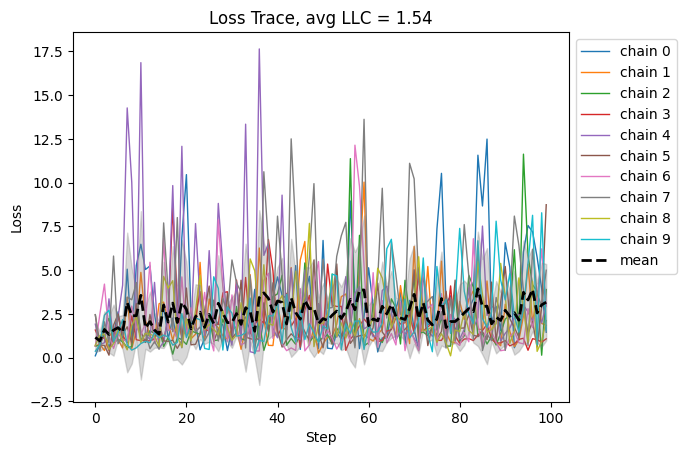

<Figure size 1200x900 with 0 Axes>

In [8]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)